In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [2]:
df1= pd.read_csv("/kaggle/input/daigt-one-place-all-data/concatenated.csv")
train_p = pd.read_csv("/kaggle/input/llm-detect-ai-generated-text/train_prompts.csv")
train_e=pd.read_csv("/kaggle/input/llm-detect-ai-generated-text/train_essays.csv")
test = pd.read_csv("/kaggle/input/llm-detect-ai-generated-text/test_essays.csv")
sample = pd.read_csv("/kaggle/input/llm-detect-ai-generated-text/sample_submission.csv")

df1.drop(columns=['id','prompt_id','model','kaggle_repo'],inplace = True)

merged_df = pd.merge(train_e, train_p, on='prompt_id')
merged_df['text'] = merged_df['text']+' '+merged_df['source_text'] + ' ' + merged_df['instructions']
df = merged_df.drop(columns = ['id','prompt_name','instructions','source_text'])
df.drop(columns = ['prompt_id'],inplace = True)

train = pd.concat([df , df1], axis =0)

In [3]:
import re
import string
import nltk
import spacy
eng = spacy.load("en_core_web_lg")
from nltk.corpus import stopwords 
stop_words = set(stopwords.words('english')) 

from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

porter = PorterStemmer()

def remove_stop_words(sentence): 
    words = sentence.split() 
    filtered_words = []
    # Use a list comprehension to remove stop words 
    filtered_words = [word for word in words if word not in stop_words] 
    # Join the filtered words back into a sentence 
    return ' '.join(filtered_words)

def remove_punct(data):
    return data.translate(str.maketrans('','',string.punctuation))

def stem_sentence(sentence):
    tokens = word_tokenize(sentence)
    stemmed_tokens = [porter.stem(token) for token in tokens]
    return ' '.join(stemmed_tokens)

def spacy(text):
    doc = eng(text)
    no_stop_words = [token.text.lower() for token in doc if not token.is_stop and not token.is_punct and not token.like_url and not token.is_digit ]
    return " ".join(no_stop_words)

def preprocess(data):
    data['text'] = data['text'].str.lower()
    data['text'] = data['text'].progress_apply(remove_punct)
    data['text'] = data['text'].progress_apply(remove_stop_words)
    data['text'] = data['text'].progress_apply(stem_sentence)
    return data

from tqdm import tqdm
tqdm.pandas()

train = preprocess(train)
test = preprocess(test)
train.to_csv("train_clean.csv")

I have already preprocessed the data using above code, it take 10 min to do this, so I have already done this and saved file locally and then uploaded it.

In [4]:
train = pd.read_csv("/kaggle/input/final-preprocessed/train_clean.csv")
train.drop(columns=['Unnamed: 0'],inplace = True)

In [5]:
y = train['generated']

In [6]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [7]:
class CFG:
    sequence_length = 1024
    vocab_size = 10000
    is_training = False

In [8]:
# Create a TextVectorization layer with specified parameters
vectorizer = tf.keras.layers.TextVectorization(
    max_tokens=CFG.vocab_size, 
    output_sequence_length=CFG.sequence_length, 
    pad_to_max_tokens=True
)
# Adapt the TextVectorization layer to the training data
vectorizer.adapt(train["text"], batch_size=1024)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, 1024)              0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 1024, 64)          640000    
                                                                 
 bidirectional (Bidirection  (None, 1024, 128)         66048     
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 64)                41216     
 onal)                                                           
                                                                 
 dense (Dense)               (None, 16)                1040      
                                                        

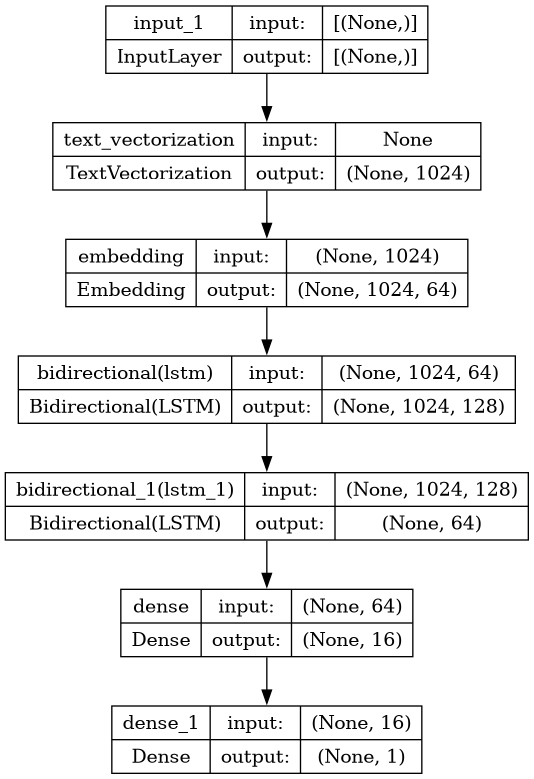

In [9]:
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(), dtype=tf.string),
    vectorizer,
    tf.keras.layers.Embedding(
        input_dim=CFG.vocab_size, 
        output_dim=64,
        input_length=CFG.sequence_length, 
        mask_zero=True
    ),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)), 
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)), 
    tf.keras.layers.Dense(16, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(), 
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), 
    metrics=[
        "accuracy", 
        tf.keras.metrics.AUC(name="auc")
    ]
)
model.summary()
tf.keras.utils.plot_model(model, show_shapes=True)

In [10]:
frequencies = y.value_counts()
weights = {0: frequencies.sum() / frequencies[0], 1: frequencies.sum() / frequencies[1]}
weights

{0: 1.7923726104469024, 1: 2.2620325170452253}

In [11]:
def create_dataset(dataframe, shuffle=True):
    # Create a TensorFlow dataset from the text and label columns of the dataframe
    dataset = tf.data.Dataset.from_tensor_slices((dataframe["text"], dataframe["generated"]))
    if shuffle:
        # Shuffle the dataset if the shuffle parameter is True
        dataset = dataset.shuffle(1024, reshuffle_each_iteration=True)
    # Batch the dataset into smaller batches of size 256
    dataset = dataset.batch(256).cache().prefetch(tf.data.AUTOTUNE)
    # Prefetch the next batch of data to further optimize training
    return dataset

In [12]:
from sklearn.model_selection import train_test_split
train_data, valid_data = train_test_split(train, test_size=0.2, stratify=train["generated"], random_state=42)
train_ds = create_dataset(train_data)
valid_ds = create_dataset(valid_data, shuffle=False)

In [13]:
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=4,
    min_delta=0.001,
    restore_best_weights=True,
    
)

model.fit(train_ds, epochs = 5,validation_data=valid_ds ,callbacks=[early_stopping],class_weight = weights)

Epoch 1/5
176/176 [==============================] - 88s 386ms/step - loss: 0.3825 - accuracy: 0.9328 - auc: 0.9761 - val_loss: 0.1088 - val_accuracy: 0.9688 - val_auc: 0.9845
Epoch 2/5
176/176 [==============================] - 33s 187ms/step - loss: 0.1411 - accuracy: 0.9804 - auc: 0.9941 - val_loss: 0.0967 - val_accuracy: 0.9742 - val_auc: 0.9917
Epoch 3/5
176/176 [==============================] - 33s 187ms/step - loss: 0.1262 - accuracy: 0.9815 - auc: 0.9958 - val_loss: 0.0485 - val_accuracy: 0.9849 - val_auc: 0.9980
Epoch 4/5
176/176 [==============================] - 32s 184ms/step - loss: 0.0717 - accuracy: 0.9899 - auc: 0.9981 - val_loss: 0.0480 - val_accuracy: 0.9851 - val_auc: 0.9973
Epoch 5/5
176/176 [==============================] - 33s 185ms/step - loss: 0.0520 - accuracy: 0.9932 - auc: 0.9987 - val_loss: 0.0451 - val_accuracy: 0.9862 - val_auc: 0.9975


In [15]:
test = pd.read_csv("/kaggle/input/llm-detect-ai-generated-text/test_essays.csv")

test["generated"] = model.predict(test["text"])

submission = test[["id", "generated"]]

submission.to_csv("submission.csv", index=False)

submission.head()

1/1 [==============================] - 0s 29ms/step


,id,generated
0,0000aaaa,0.301037
1,1111bbbb,0.157540
2,2222cccc,0.157540
